# Steam Game Analysis
This data set covers all the games released before 2017 on Valve's Steam platform, pulled from SteamSpy. I would like to see if there are predictors of the estimated player count given other factors. 

In [3]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import statsmodels.formula.api as smf 

In [4]:
raw_data = pd.read_csv('games.csv')

## Data Cleaning

We should first filter out the rows which contain only a few players because this will help reduce the clutter in our dataset.

In [5]:
raw_data.columns

Index(['responsename', 'releasedate', 'metacritic', 'steamspyowners',
       'steamspyownersvariance', 'steamspyplayersestimate',
       'steamspyplayersvariance', 'achievementcount', 'categorysingleplayer',
       'genreisindie', 'genreisaction', 'genreisadventure', 'genreiscasual',
       'genreisstrategy', 'genreisrpg', 'genreissimulation', 'genreissports',
       'genreisracing', 'pricecurrency', 'pricefinal'],
      dtype='object')

In [6]:
data = raw_data[(raw_data['steamspyplayersestimate']>10000) & (raw_data['metacritic']>0)]

We also would like to process the release date in a numeraical method for easier regression later. 

In [7]:
date_sub = data[["responsename", "releasedate"]].dropna()
is_date = date_sub.releasedate.apply(lambda s: (s.lower().find("soon") == -1 and s.lower().find("com") == -1 and s.lower().find("tbd") == -1))
date_sub = date_sub[is_date]

We should double check the formats of the dates.

In [8]:
def isformat(d):
    '''
    Despite the name of the function, returns True if it doesn't follow the expected format.
    '''
    try:
        pd.datetime.strptime(d, "%b %d %Y")
        return False
    except:
        return True
    return None
date_sub[date_sub.releasedate.apply(isformat)]

,responsename,releasedate
305,Test Drive Unlimited 2,Feb 2011
668,Blueberry Garden,Jun 2009
687,Puzzle Agent,Jul 2010
904,Darkest of Days,Sep 2009
1180,Silent Hunter 5(r): Battle of the Atlantic,Mar 2010
1228,Flotilla,Apr 2010
1253,Turba,Jul 2010
1268,Age of Wonders II: The Wizards Throne,Oct 2010
1269,Age of Wonders Shadow Magic,Oct 2010
2317,Inquisitor,Aug 2013


In [9]:
def date_impute(d):
    parts = d.split()
    if len(parts) == 2:
        parts.insert(1, "15") # Impute the middle of the month
    date = " ".join(parts)
    return pd.datetime.strptime(date, "%b %d %Y")
date_sub.releasedate = date_sub.releasedate.apply(date_impute)

In [10]:
data_trimmed = pd.merge(date_sub, data.drop("releasedate",axis=1), how="left", on="responsename").drop_duplicates()

In [11]:
data_trimmed

,responsename,releasedate,metacritic,steamspyowners,steamspyownersvariance,steamspyplayersestimate,steamspyplayersvariance,achievementcount,categorysingleplayer,genreisindie,genreisaction,genreisadventure,genreiscasual,genreisstrategy,genreisrpg,genreissimulation,genreissports,genreisracing,pricecurrency,pricefinal
0,Counter-Strike,2000-11-01,88,13033334,92789,9140731,78136,0,False,False,True,False,False,False,False,False,False,False,USD,9.99
1,Day of Defeat,2003-05-01,79,7621102,71499,1709740,34145,0,False,False,True,False,False,False,False,False,False,False,USD,4.99
2,Half-Life,1998-11-08,96,5927504,63206,2268772,39303,0,True,False,True,False,False,False,False,False,False,False,USD,9.99
3,Counter-Strike: Condition Zero,2004-03-01,65,10489261,83543,4127910,52878,0,True,False,True,False,False,False,False,False,False,False,USD,9.99
5,Counter-Strike: Condition Zero,2004-03-01,65,10489261,83543,1870437,35706,0,True,False,True,False,False,False,False,False,False,False,USD,9.99
9,Half-Life: Blue Shift,2001-06-01,71,5368650,60199,662517,21286,0,True,False,True,False,False,False,False,False,False,False,USD,4.99
10,Half-Life 2,2004-11-16,96,9901173,81234,5695963,61979,33,True,False,True,False,False,False,False,False,False,False,USD,9.99
11,Counter-Strike: Source,2004-11-01,88,15433570,100626,11472993,87251,147,False,False,True,False,False,False,False,False,False,False,USD,19.99
12,Day of Defeat: Source,2010-07-12,80,6400269,65635,2895778,44364,54,False,False,True,False,False,False,False,False,False,False,USD,9.99
13,Half-Life 2: Episode One,2006-06-01,87,6298399,65120,2478611,41068,13,True,False,True,False,False,False,False,False,False,False,USD,7.99


Next we would like to check that all the currencies are the same, and if they aren't, convert them. 

In [12]:
print(data_trimmed.pricecurrency.unique())
data_trimmed[data_trimmed.pricecurrency != 'USD'][["responsename", "pricecurrency", "pricefinal"]].head()

['USD' nan]


,responsename,pricecurrency,pricefinal
16,Team Fortress 2,NaN,0.0
19,Dota 2,NaN,0.0
22,Alien Swarm,NaN,0.0
74,Vigil: Blood Bitterness(tm),NaN,0.0
126,Titan Quest,NaN,0.0
127,Titan Quest - Immortal Throne,NaN,0.0
160,Bloodline Champions,NaN,0.0
199,Sam & Max 201: Ice Station Santa,NaN,0.0
200,Sam & Max 202: Moai Better Blues,NaN,0.0
201,Sam & Max 203: Night of the Raving Dead,NaN,0.0


It seems that all the prices which are listed as not in USD are free, with a price of 0. Thus, we can ignore the `pricecurrency` column in our later analysis. 

## Preliminary Exploratory Analysis
I think the first thing that needs to be looked at is the proportion of the categorical variables that we have. 

In [13]:
cat_percents = data_trimmed.iloc[:,8:18].aggregate(np.sum) / len(data_trimmed)
cat_percents

categorysingleplayer    0.954323
genreisindie            0.436650
genreisaction           0.498641
genreisadventure        0.314301
genreiscasual           0.090266
genreisstrategy         0.276781
genreisrpg              0.196302
genreissimulation       0.118543
genreissports           0.028276
genreisracing           0.041871
dtype: float64

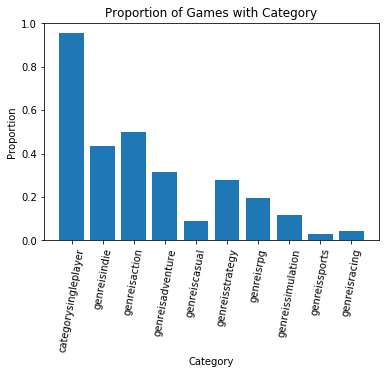

In [14]:
plt.bar(cat_percents.index, cat_percents.values)
plt.xlabel("Category")
plt.xticks(rotation=80)
plt.ylabel("Proportion")
plt.title("Proportion of Games with Category")
plt.show()

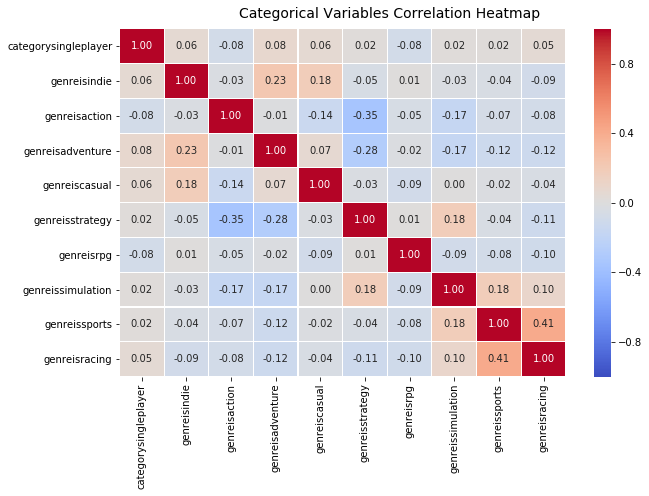

In [15]:
# Correlation matrix-like visualization
f, ax = plt.subplots(figsize=(10, 6))
corr = data_trimmed.iloc[:,8:18].corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
                 linewidths=.05, vmin=-1)
f.subplots_adjust(top=0.93)
t= f.suptitle('Categorical Variables Correlation Heatmap', fontsize=14)

This heatmap shows something that is good for analysis: none of the categorical variables are strongly correlated with each other so multicolinearity is not something that needs to be greatly worried about. 

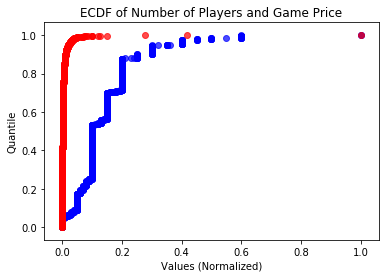

In [16]:
# Distribution of the price variable
def ecdf(data, normal=True):
    # Compute the ECDF 
    x = np.sort(data)
    if normal:
        x = (x-x[0])/x[-1]
    n = x.size
    y = np.arange(1, n+1) / n
    return(x,y)
price_x, price_y = ecdf(data_trimmed.pricefinal)
players_x, players_y = ecdf(data_trimmed.steamspyplayersestimate)
plt.scatter(price_x, price_y, color="blue", alpha=0.7)
plt.scatter(players_x, players_y, color="red", alpha=0.7)
plt.xlabel("Values (Normalized)")
plt.ylabel("Quantile")
plt.title("ECDF of Number of Players and Game Price")
plt.show()

It is rather clear that the game price is not linear and has a significant tail, but this tail is not quite as thin as the one for the number of players. It is probably worth doing something like a log transform of the number of players first. 

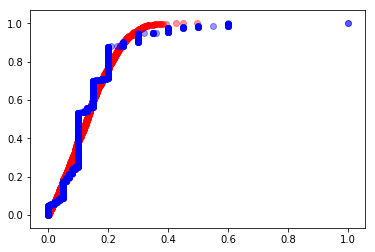

In [17]:
players_x_ln, players_y_ln = ecdf(np.log(data_trimmed.steamspyplayersestimate))
plt.scatter(players_x_ln, players_y_ln, color="red", alpha=0.4)
plt.scatter(price_x, price_y, color="blue", alpha=0.4)

After taking the log of the number of players, it seems to be a much better fit of the two distributions. Let's see if the two distributions correspond to each other. 

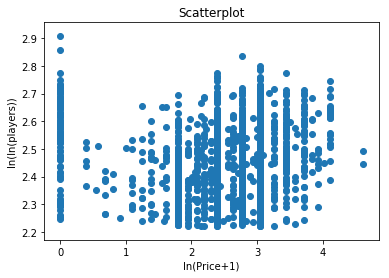

In [18]:
plt.scatter(np.log(data_trimmed.pricefinal+1), np.log(np.log(data_trimmed.steamspyplayersestimate)))
plt.xlabel("ln(Price+1)")
plt.ylabel("ln(ln(players))")
plt.title("Scatterplot")
plt.show()

Surprisingly, there seems to be some weak positive trend to this scatterplot of price and number of players. 

## Data Analysis
If we wanted to predict the number of owners of a game from the data, we will need to account for the fact that the longer a game has been out, the more likely it will accumulate owners, as people will have had more of a chance to go buy the game. However, as far as I can tell, there does not exist a package in Python which supports an exposure variable in the GLM framework, so this is going to need to be bodged in. 

We know that for exposure in Poisson regression we take the response variate as a rate of the response variate over the exposure, which is the number of days the game has been out. Since the canonical link for Poisson regression is $X\beta = \eta(\mu) = \ln(\mu)$, this is the same as subtracting the logorithm from the left side. Thus, we want $\ln\left(\frac{players}{days}\right) = X\beta$

In [19]:
def change_to_rate(players, time, transform=lambda x: x):
    duration = (pd.Timestamp(2017,1,1) - time).apply(lambda x: x.days)
    return players.apply(transform) / duration

In [20]:
p_rate = change_to_rate(data_trimmed.steamspyowners, data_trimmed.releasedate)
X_train, X_test, y_train, y_test = train_test_split(data_trimmed, p_rate, test_size=0.1, random_state=42)
poisson_data = X_train.assign(player_rate = y_train)
poisson_mod = smf.glm(formula = "player_rate ~ pricefinal + metacritic + categorysingleplayer + genreisindie + genreisaction + genreisadventure + genreiscasual + genreisstrategy + genreisrpg + genreissimulation + genreissports + genreisracing", data=poisson_data, family=sm.families.Poisson()).fit()
poisson_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            player_rate   No. Observations:                 1655
Model:                            GLM   Df Residuals:                     1642
Model Family:                 Poisson   Df Model:                           12
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -7.8299e+05
Date:                Mon, 14 Oct 2019   Deviance:                   1.5543e+06
Time:                        17:16:27   Pearson chi2:                 3.92e+06
No. Iterations:                     7   Covariance Type:             nonrobust
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        1.5902      0.011    149.538      0.000       1.569       1.611
categorysingleplayer[T.True]    -1.9516      0.003   -727.671      0.000      -1.957      -1.946
genreisindie[T.True]            -0.2493      0.002   -107.199      0.000      -0.254      -0.245
genreisaction[T.True]            0.6381      0.002    260.038      0.000       0.633       0.643
genreisadventure[T.True]         0.1242      0.002     50.324      0.000       0.119       0.129
genreiscasual[T.True]            0.2193      0.005     45.824      0.000       0.210       0.229
genreisstrategy[T.True]          0.3082      0.003    116.879      0.000       0.303       0.313
genreisrpg[T.True]               0.1852      0.003     72.752      0.000       0.180       0.190
genreissimulation[T.True]        0.4739      0.003    144.407      0.000       0.467       0.480
genreissports[T.True]            0.2853      0.007     42.867      0.000       0.272       0.298
genreisracing[T.True]           -0.0518      0.007     -7.486      0.000      -0.065      -0.038
pricefinal                       0.0216   6.68e-05    323.947      0.000       0.021       0.022
metacritic                       0.0734      0.000    578.946      0.000       0.073       0.074
================================================================================================
"""

In [29]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [30]:
rmse(poisson_mod.predict(X_test), y_test)

623.1792002245116

This number by itself doesn't mean much, but serves as a baseline to compare other models against. For example, from our exploratory phase we discovered that it might be sensible to take the log transform of the number of players to change it from a Pareto-like distribution to something that is more balanced. We can investigate this with the following: 

In [31]:
p_rate_l = change_to_rate(data_trimmed.steamspyowners, data_trimmed.releasedate, np.log)
X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(data_trimmed, p_rate_l, test_size=0.1, random_state=42)
poisson_data_l = X_train_l.assign(player_rate = y_train_l)
poisson_mod_l = smf.glm(formula = "player_rate ~ pricefinal + metacritic + categorysingleplayer + genreisindie + genreisaction + genreisadventure + genreiscasual + genreisstrategy + genreisrpg + genreissimulation + genreissports + genreisracing", data=poisson_data_l, family=sm.families.Poisson()).fit()
poisson_mod_l.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            player_rate   No. Observations:                 1655
Model:                            GLM   Df Residuals:                     1642
Model Family:                 Poisson   Df Model:                           12
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -105.75
Date:                Mon, 14 Oct 2019   Deviance:                       14.437
Time:                        17:29:40   Pearson chi2:                     23.9
No. Iterations:                     5   Covariance Type:             nonrobust
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       -4.8375      1.823     -2.653      0.008      -8.411      -1.264
categorysingleplayer[T.True]    -0.4456      0.938     -0.475      0.635      -2.284       1.393
genreisindie[T.True]             0.3861      0.443      0.871      0.384      -0.483       1.255
genreisaction[T.True]           -0.0326      0.463     -0.070      0.944      -0.939       0.874
genreisadventure[T.True]         0.2934      0.485      0.605      0.545      -0.656       1.243
genreiscasual[T.True]           -0.0806      0.815     -0.099      0.921      -1.677       1.516
genreisstrategy[T.True]          0.0819      0.536      0.153      0.879      -0.968       1.132
genreisrpg[T.True]               0.1460      0.525      0.278      0.781      -0.882       1.174
genreissimulation[T.True]        0.1757      0.645      0.272      0.785      -1.088       1.440
genreissports[T.True]            0.4044      1.162      0.348      0.728      -1.873       2.682
genreisracing[T.True]            0.1162      1.150      0.101      0.920      -2.138       2.371
pricefinal                       0.0273      0.014      1.927      0.054      -0.000       0.055
metacritic                       0.0024      0.021      0.114      0.909      -0.039       0.043
================================================================================================
"""

In [32]:
rmse(poisson_mod_l.predict(X_test_l), y_test_l)

0.015458902416235097

We can see a marked improvement after the transform, both in the increase of the log-likelihood and in the drop of the RMSE value. We can also see that pretty much all of the features are no longer significant, which is a sign of overfitting and requires some trimming to be able to make some sense. We shall use a random forest for feature importance. 

In [43]:
# Random Forest for feature selection
# ref: https://towardsdatascience.com/random-forest-in-python-24d0893d51c0
from sklearn.ensemble import RandomForestRegressor

X_train_l_rf = X_train_l[["pricefinal", "metacritic", "categorysingleplayer", "genreisindie", "genreisaction", "genreisadventure", "genreiscasual", "genreisstrategy", "genreisrpg", "genreissimulation", "genreissports", "genreisracing"]]
X_test_l_rf = X_test_l[["pricefinal", "metacritic", "categorysingleplayer", "genreisindie", "genreisaction", "genreisadventure", "genreiscasual", "genreisstrategy", "genreisrpg", "genreissimulation", "genreissports", "genreisracing"]]
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf.fit(X_train_l_rf, y_train_l)
rmse(rf.predict(X_test_l_rf), y_test_l)

0.020163461916487192

In [46]:
# Get numerical feature importances
importances = list(rf.feature_importances_)# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(X_train_l_rf.columns, importances)]# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)# Print out the feature and importances 
['Variable: {:20} Importance: {}'.format(*pair) for pair in feature_importances]

['Variable: metacritic           Importance: 0.32',
 'Variable: pricefinal           Importance: 0.29',
 'Variable: genreisstrategy      Importance: 0.08',
 'Variable: genreisadventure     Importance: 0.07',
 'Variable: genreisindie         Importance: 0.05',
 'Variable: genreisaction        Importance: 0.05',
 'Variable: genreisrpg           Importance: 0.04',
 'Variable: genreissimulation    Importance: 0.03',
 'Variable: categorysingleplayer Importance: 0.02',
 'Variable: genreissports        Importance: 0.02',
 'Variable: genreisracing        Importance: 0.02',
 'Variable: genreiscasual        Importance: 0.01']